# Exercise 6: Question Answering

This session is based on lecture 11 (Question Answering).

Relevant SLP chapters:
* Chapter 14 (except 14.1 and 14.2)

## Extractive QA : SQuAD

In this exercise, we will learn how to finetune a transformer model on question answering, specifically extractive question answering, which is to predict / select the answer to a question given some context.
The benchmark dataset for extractive question answering is [SQuAD](https://huggingface.co/datasets/rajpurkar/squad).

We will finetune BERT on this dataset. (You are also free to explore other models).

Connecting to a GPU runtime in Google Colab is highly recommended for this exercise.

This is a fill in the blank exercise, where you are expected to fill in parts of the code marked `# TODO: your code here`.

This exercise is adapted from [huggingface](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/question_answering-tf.ipynb#scrollTo=i5o_4_4SwQDY).

### Part 1: The dataset

In [ ]:
!pip install -q "transformers[torch]" datasets evaluate "accelerate" pandas

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import (
    load_dataset,
)
from IPython.display import HTML, display
from torch.utils.data import DataLoader
from transformers import (
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    DefaultDataCollator,
)
from tqdm.auto import tqdm

In [ ]:
# we will only use a subset of the train split for squad for training because of limited compute and time
squad = load_dataset("squad", split="train[:2500]")

In [ ]:
squad.column_names

['id', 'title', 'context', 'question', 'answers']

In [ ]:
# We'll turn the dataset in to a dataframe for easier inspection
squad_df = squad.to_pandas()

In [ ]:
# Re-run this cell to see some other random examples
display(HTML(squad_df.sample(10).to_html()))

,id,title,context,question,answers
117,5733926d4776f41900660d90,University_of_Notre_Dame,"The Rev. John J. Cavanaugh, C.S.C. served as president from 1946 to 1952. Cavanaugh's legacy at Notre Dame in the post-war years was devoted to raising academic standards and reshaping the university administration to suit it to an enlarged educational mission and an expanded student body and stressing advanced studies and research at a time when Notre Dame quadrupled in student census, undergraduate enrollment increased by more than half, and graduate student enrollment grew fivefold. Cavanaugh also established the Lobund Institute for Animal Studies and Notre Dame's Medieval Institute. Cavanaugh also presided over the construction of the Nieuwland Science Hall, Fisher Hall, and the Morris Inn, as well as the Hall of Liberal Arts (now O'Shaughnessy Hall), made possible by a donation from I.A. O'Shaughnessy, at the time the largest ever made to an American Catholic university. Cavanaugh also established a system of advisory councils at the university, which continue today and are vital to the university's governance and development","Outside of an institute studying animals, what other institute did Cavanugh create at Notre Dame?","{'text': ['Medieval Institute'], 'answer_start': [575]}"
946,56d4efd92ccc5a1400d83379,Beyoncé,"The release of a video-game Starpower: Beyoncé was cancelled after Beyoncé pulled out of a $100 million with GateFive who alleged the cancellation meant the sacking of 70 staff and millions of pounds lost in development. It was settled out of court by her lawyers in June 2013 who said that they had cancelled because GateFive had lost its financial backers. Beyoncé also has had deals with American Express, Nintendo DS and L'Oréal since the age of 18.",When was the disagreement settled out of court?,"{'text': ['June 2013'], 'answer_start': [267]}"
1855,56cc100b6d243a140015ee8a,Frédéric_Chopin,"During the summers at Nohant, particularly in the years 1839–43, Chopin found quiet, productive days during which he composed many works, including his Polonaise in A-flat major, Op. 53. Among the visitors to Nohant were Delacroix and the mezzo-soprano Pauline Viardot, whom Chopin had advised on piano technique and composition. Delacroix gives an account of staying at Nohant in a letter of 7 June 1842:",What is the example given of a work produced by Frédéric during calm summers at Nohant?,"{'text': ['Polonaise in A-flat major, Op. 53'], 'answer_start': [152]}"
752,56bfbf2fa10cfb14005512a3,Beyoncé,"Beyoncé has stated that she is personally inspired by US First Lady Michelle Obama, saying ""She proves you can do it all"" and she has described Oprah Winfrey as ""the definition of inspiration and a strong woman"". She has also discussed how Jay Z is a continuing inspiration to her, both with what she describes as his lyrical genius and in the obstacles he has overcome in his life. Beyoncé has expressed admiration for the artist Jean-Michel Basquiat, posting in a letter ""what I find in the work of Jean-Michel Basquiat, I search for in every day in music... he is lyrical and raw"". In February 2013, Beyoncé said that Madonna inspired her to take control of her own career. She commented: ""I think about Madonna and how she took all of the great things she achieved and started the label and developed other artists. But there are not enough of those women."".",How does she describe Jean- Michel Basquiat?,"{'text': ['lyrical and raw'], 'answer_start': [567]}"
2151,56cffa2a234ae51400d9c1d1,Frédéric_Chopin,"With his mazurkas and polonaises, Chopin has been credited with introducing to music a new sense of nationalism. Schumann, in his 1836 review of the piano concertos, highlighted the composer's strong feelings for his native Poland, writing that ""Now that the Poles are in deep mourning [after the failure of the November 1830 rising], their appeal to us artists is even stronger ... If the mighty autocrat in the north [i.e. Nicholas I of R

If you look at the example from the dataset above, you have an example ID, the
title, the context for extracting the answer, the question, and the answer with includes the index of the starting character of the answer in the context.
The model will be train to predict these spans.

### Part 2: Preprocessing

The SQuAD finetuning pipeline requires more preprocessing than the average text classification dataset. We will use the transformers tokenizers library that we briefly introduced in Exercise 1 to tokenize our text and preprocess the text.

In [ ]:
model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# these variables will become clear later
doc_stride = 128
max_token_length = 512
squad_v2 = False
pad_on_right = tokenizer.padding_side == "right"

Now one specific thing for the preprocessing in question answering is how to deal with very long documents.



Some examples in a dataset may have a very long `context` that exceeds the maximum input length of the model. To deal with longer sequences, we can truncate (shorten) only the `context` by setting `truncation="only_second"`.
Next, we can map the start and end positions of the answer to the original `context` by setting `return_offset_mapping=True`.
With the mapping in hand, now we can find the start and end tokens of the answer. We will use the `sequence_ids` method to find which part of the offset corresponds to the `question` and which corresponds to the `context`.


In [ ]:
example = None

for ex in squad:
    if len(tokenizer(ex["question"], ex["context"])["input_ids"]) > max_token_length:
        example = ex
        break

example

{'id': '56ce4a58aab44d1400b88668',
 'title': 'Sino-Tibetan_relations_during_the_Ming_dynasty',
 'context': 'In 1565, the powerful Rinbung princes were overthrown by one of their own ministers, Karma Tseten who styled himself as the Tsangpa, "the one of Tsang", and established his base of power at Shigatse. The second successor of this first Tsang king, Karma Phuntsok Namgyal, took control of the whole of Central Tibet (Ü-Tsang), reigning from 1611–1621. Despite this, the leaders of Lhasa still claimed their allegiance to the Phagmodru as well as the Gelug, while the Ü-Tsang king allied with the Karmapa. Tensions rose between the nationalistic Ü-Tsang ruler and the Mongols who safeguarded their Mongol Dalai Lama in Lhasa. The fourth Dalai Lama refused to give an audience to the Ü-Tsang king, which sparked a conflict as the latter began assaulting Gelug monasteries. Chen writes of the speculation over the fourth Dalai Lama\'s mysterious death and the plot of the Ü-Tsang king to have him 

Without any truncation, we get the following length for the input IDs:

In [ ]:
len(tokenizer(example["question"], example["context"])["input_ids"])

518

Now, if we just truncate, we will lose information (and possibly the answer to our question):

In [ ]:
len(
    tokenizer(
        example["question"],
        example["context"],
        max_length=max_token_length,
        truncation="only_second",
    )["input_ids"]
)

512

Removing part of the `context` might result in losing the answer we are looking for. To deal with this, we will allow one (long) example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter). We can enable this functionality by setting `return_overflowing_tokens=True`. Also, just in case the answer lies at the point we split a long context, we allow some overlap between the features we generate controlled by the hyper-parameter `doc_stride`.

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_token_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride,
)

Now we don't have one list of `input_ids`, but several:

In [ ]:
[len(x) for x in tokenized_example["input_ids"]]

[512, 147]

And if we decode them, we can see the overlap:

In [ ]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] when were the rinbung princes overthrown? [SEP] in 1565, the powerful rinbung princes were overthrown by one of their own ministers, karma tseten who styled himself as the tsangpa, " the one of tsang ", and established his base of power at shigatse. the second successor of this first tsang king, karma phuntsok namgyal, took control of the whole of central tibet ( u - tsang ), reigning from 1611 – 1621. despite this, the leaders of lhasa still claimed their allegiance to the phagmodru as well as the gelug, while the u - tsang king allied with the karmapa. tensions rose between the nationalistic u - tsang ruler and the mongols who safeguarded their mongol dalai lama in lhasa. the fourth dalai lama refused to give an audience to the u - tsang king, which sparked a conflict as the latter began assaulting gelug monasteries. chen writes of the speculation over the fourth dalai lama ' s mysterious death and the plot of the u - tsang king to have him murdered for " cursing " him with ill

We need to find in which of those words the answer actually is, and where exactly in that context.
The models we will use require the start and end positions of these answers in the tokens, so we will also need to to map parts of the original context to some tokens.
The tokenizer we're using can help us with that by returning an `offset_mapping`:

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_token_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride,
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 4), (5, 9), (10, 13), (14, 16), (16, 18), (18, 21), (22, 29), (30, 39), (39, 40), (40, 41), (0, 0), (0, 2), (3, 6), (6, 7), (7, 8), (9, 12), (13, 21), (22, 24), (24, 26), (26, 29), (30, 37), (38, 42), (43, 52), (52, 53), (54, 56), (57, 60), (61, 63), (64, 69), (70, 73), (74, 83), (83, 84), (85, 90), (91, 93), (93, 96), (96, 97), (98, 101), (102, 108), (109, 116), (117, 119), (120, 123), (124, 126), (126, 129), (129, 131), (131, 132), (133, 134), (134, 137), (138, 141), (142, 144), (145, 147), (147, 150), (150, 151), (151, 152), (153, 156), (157, 168), (169, 172), (173, 177), (178, 180), (181, 186), (187, 189), (190, 193), (193, 196), (196, 198), (198, 199), (200, 203), (204, 210), (211, 220), (221, 223), (224, 228), (229, 234), (235, 237), (237, 240), (241, 245), (245, 246), (247, 252), (253, 255), (255, 258), (258, 260), (260, 261), (262, 265), (265, 267), (267, 269), (269, 270), (271, 275), (276, 283), (284, 286), (287, 290), (291, 296), (297, 299), (300, 307), (308, 313

This gives the corresponding start and end character in the original text for each token in our input IDs. The very first token (`[CLS]`) has (0, 0) because it doesn't correspond to any part of the question/answer, then the second token is the same as the characters 0 to 3 of the question:

In [ ]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(
    tokenizer.convert_ids_to_tokens([first_token_id])[0],
    example["question"][offsets[0] : offsets[1]],
)

when When


So we can use this mapping to find the position of the start and end tokens of our answer in a given feature. We just have to distinguish which parts of the offsets correspond to the question and which part correspond to the context, this is where the `sequence_ids` method of our `tokenized_example` can be useful:

In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

It returns `None` for the special tokens, then 0 or 1 depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context). Now with all of this, we can find the first and last token of the answer in one of our input feature:

In [ ]:
answers = example["answers"]  # testing on one example
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

offsets = tokenized_example["offset_mapping"][0]
while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
    token_start_index += 1
start_position = token_start_index - 1
while offsets[token_end_index][1] >= end_char:
    token_end_index -= 1
end_position = token_end_index + 1
print(start_position, end_position)

13 14


In [ ]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position : end_position + 1]))
print(answers["text"][0])

1565
1565


Now let's put everything together in one function we will apply to our training set. In the case of impossible answers (the answer is in another feature given by an example with a long context), we set the cls index for both the start and end position.

In [ ]:
def preprocess(examples):
    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_token_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        # -- ANSWER TO PART 5
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
            continue
        # -- END ANSWER TO PART 5

        # Start/end character index of the answer in the text.
        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        # Start token index of the current span in the text.
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        # End token index of the current span in the text.
        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
        if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
            # Note: we could go after the last offset if the answer is the last word (edge case).
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            tokenized_examples["start_positions"].append(token_start_index - 1)
            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [ ]:
features = preprocess(squad[:2])
features

{'input_ids': [[101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 1010, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271, 1999, 8517, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1006, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 1017, 11342, 1998, 1996, 2

In [ ]:
# the datasets library has a .map() function that allows you to apply any function to each example in the dataset
# it also allows for batching, so we can set batched=True for faster processing

tokenized_squad = squad.map(preprocess, batched=True, remove_columns=squad.column_names)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

### Part 3: Finetuning

In [ ]:
# this will give some warnings you can ignore
model = AutoModelForQuestionAnswering.from_pretrained(model_id)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data_collator = DefaultDataCollator()
train_loader = DataLoader(tokenized_squad, batch_size=16, shuffle=True, collate_fn=data_collator)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# move model over to detected device
model.to(device)
# initialize our optimizer
optim = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [ ]:
# set model to train mode
model.train()

n_epochs = 3

# This will take about 15 minutes on a GPU, keep this in mind when doing to exercise!
for epoch in range(n_epochs):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model(
            input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions
        )
        # extract loss
        loss = outputs[0]
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

We will now perform inference on our trained model.
Let's define our question and context:

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

# This is just for the answers so you don't have to re-train a model
model = AutoModelForQuestionAnswering.from_pretrained("huggingface-course/bert-finetuned-squad")
model.to(device)
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/bert-finetuned-squad")

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
question = "How many programming languages does BLOOM support?"
context = "BLOOM has 176 billion parameters and can generate text in 46 languages natural languages and 13 programming languages."

In [ ]:
inputs = tokenizer(question, context, return_tensors="pt").to(device)

In [ ]:
# we won't compute gradients since we only want to do inference
with torch.no_grad():
    outputs = model(**inputs)  # do a forward pass in the model
    print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-10.4246, -10.4897, -10.9211, -10.4843, -11.3842, -10.8333, -10.4549,
         -10.2718, -10.2180, -10.7649, -10.8788, -10.9290, -10.1790,  -6.5689,
          -6.2534,  -8.0384,  -7.5597,  -8.6582,   0.3628,  -3.8679,  -6.4921,
          -8.9974,  -6.2237,  -7.2221,  -5.2520,  -8.2349,   1.4630,  -4.0196,
          -3.7181,  -4.5850,  -4.8677,   9.2855,  -3.0214,  -3.8526,  -5.3814,
         -10.1791]]), end_logits=tensor([[-10.0024, -10.3794,  -9.8548, -10.5490,  -9.0766, -10.3422, -10.9382,
         -10.1163, -10.0717,  -9.9332, -10.4017, -10.4867,  -7.9073,  -9.1231,
          -6.5851,  -8.3530,  -6.6256,  -9.8334,  -0.7214,  -1.3846,  -3.2450,
          -9.1996,  -8.9162,  -8.7306,  -3.8445,  -7.8523,   1.4239,  -1.3562,
          -4.0914,  -1.9703,  -4.3327,   9.7310,   0.3973,   5.5410,   2.1477,
          -7.9073]]), hidden_states=None, attentions=None)


In [ ]:
answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()

In [ ]:
predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]  # get the tokenized answer
tokenizer.decode(predict_answer_tokens)  # convert those tokens to readable text

'13'

#### Visualising the scores

We can visualize tokens in the sequence and the scores the model assigns to them.
With this, we have some idea of what the model is looking for in answering these questions.

In [ ]:
# Use plot styling from seaborn and increase size
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (20, 10)

Retrieve all of the start and end scores, and use all of the tokens as x-axis labels.

In [ ]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = outputs.start_logits.detach().cpu().numpy().flatten()
e_scores = outputs.end_logits.detach().cpu().numpy().flatten()

# We'll use the tokens as the y-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
token_labels = [f"{tok} - {idx}" for idx, tok in enumerate(tokens)]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Create a bar plot showing the score for every input word being the "start" word.

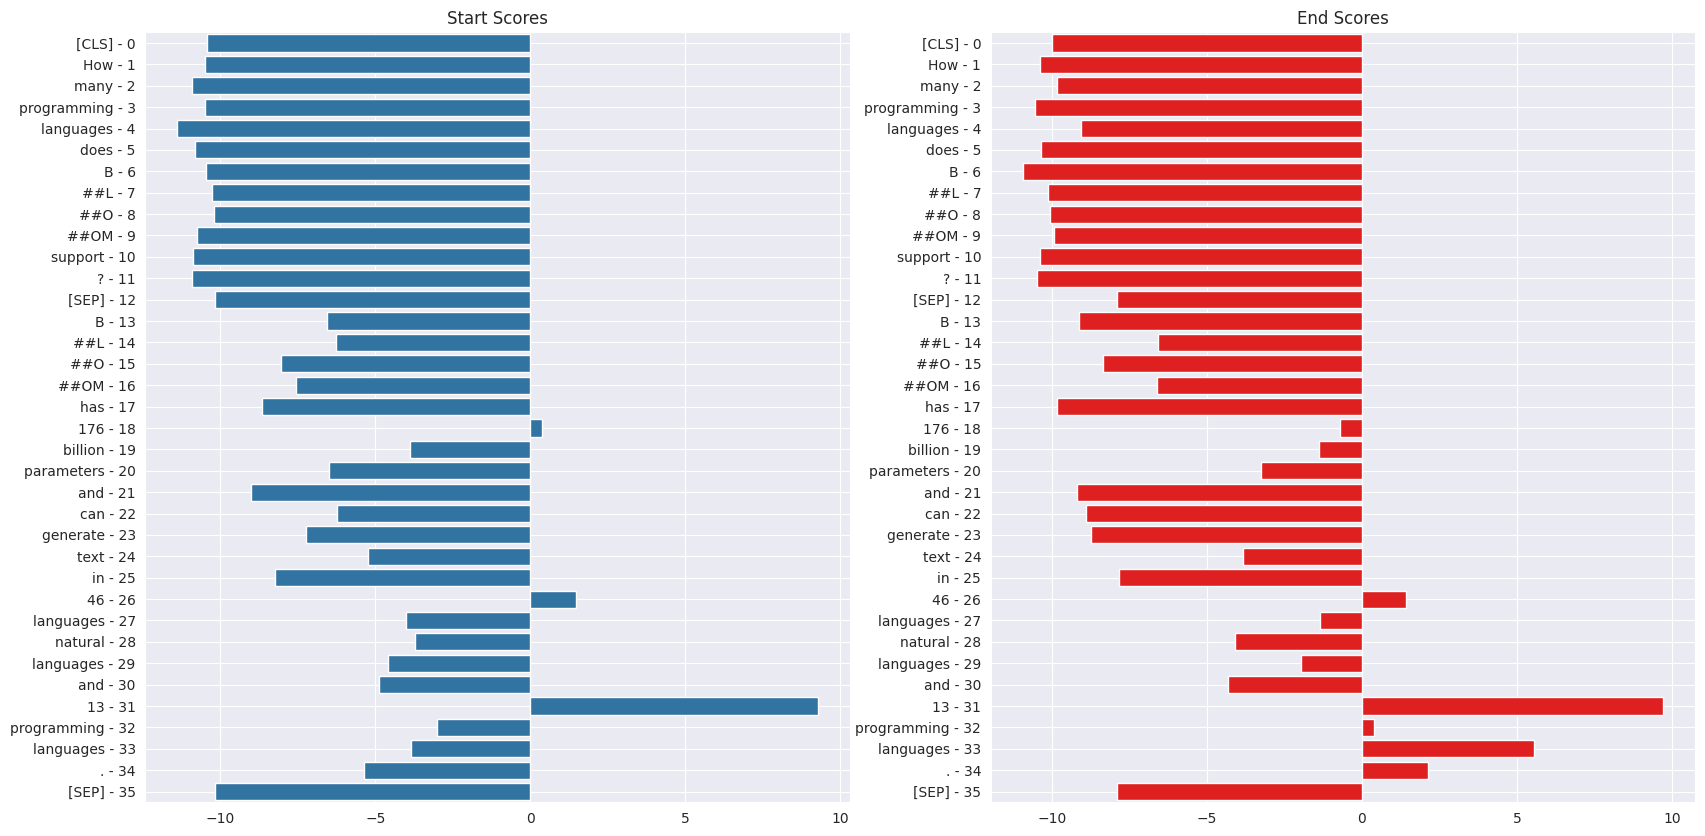

In [ ]:
# Create a barplot showing the start word score for all of the tokens.
fig, ax = plt.subplots(1, 2)
ax1 = sns.barplot(x=s_scores, y=token_labels, ax=ax[0])
ax2 = sns.barplot(x=e_scores, y=token_labels, ax=ax[1], color="red")

ax1.grid(True)
ax2.grid(True)

ax1.set_title("Start Scores")
ax2.set_title("End Scores")

plt.show()

Try out some other examples.
See how the scores change, try to come up with some hard examples.
You can take inspiration from what we've seen in the course:
* amibiguity in several ways (structural, lexical, etc.)
* spelling errors
* non-standard text
* ...

Explore what's easy and what's hard for the model.

### Part 4: Evaluation

Extractive QA is harder to evaluate than just comparing labels; more processing is needed.
We need to make sure we can map model predictions back to the context and compare this with the intended answer if we want to evaluate the model.

In [ ]:
squad_val = load_dataset("squad", split="validation[200:204]")  # Again a smaller sample
squad_val_tokenized = squad_val.map(preprocess, batched=True, remove_columns=squad_val.column_names)
val_loader = DataLoader(squad_val_tokenized, batch_size=4, shuffle=False, collate_fn=DefaultDataCollator())

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

In [ ]:
batch = next(iter(val_loader))
batch = {k: v.to(device) for k, v in batch.items()}

with torch.no_grad():
    output = model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [ ]:
batch

{'input_ids': tensor([[  101,  2627,  1125,  ...,     0,     0,     0],
         [  101,  1731,  1242,  ...,     0,     0,     0],
         [  101,  1731,  1242,  ...,     0,     0,     0],
         [  101,  1327, 19719,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'start_positions': tensor([ 40, 171, 188,  28]),
 'end_positions': tensor([ 41, 171, 188,  30])}

In [ ]:
print((output.start_logits.shape, output.end_logits.shape))

print(output.start_logits.argmax(-1))
print(output.end_logits.argmax(-1))

(torch.Size([4, 512]), torch.Size([4, 512]))
tensor([ 40, 171, 188,  28])
tensor([ 41, 171, 188,  30])


We have one logit for each feature and each token. The most obvious thing to predict an answer for each feature is to take the index for the maximum of the start logits as a start position and the index of the maximum of the end logits as an end position.

This will work great in a lot of cases, but what if this prediction gives us something impossible: the start position could be greater than the end position, or point to a span of text in the question instead of the answer. In that case, we might want to look at the second best prediction to see if it gives a possible answer and select that instead.

However, picking the second best answer is not as easy as picking the best one: is it the second best index in the start logits with the best index in the end logits? Or the best index in the start logits with the second best index in the end logits? And if that second best answer is not possible either, it gets even trickier for the third best answer.

To classify our answers, we will use the score obtained by adding the start and end logits. We won't try to order all the possible answers and limit ourselves to with a hyper-parameter we call n_best_size. We'll pick the best indices in the start and end logits and gather all the answers this predicts. After checking if each one is valid, we will sort them by their score and keep the best one.

The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:

* the ID of the example that generated the feature (since each example can generate several features, as seen before);
* the offset mapping that will give us a map from token indices to character positions in the context.

That's why we will re-process the validation set with the following function, slightly different from prepare_train_features:


In [ ]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_token_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to [] the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else [])
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
validation_features = squad_val.map(
    prepare_validation_features,
    batched=True,
    remove_columns=squad_val.column_names,
)
val_loader = DataLoader(validation_features, batch_size=4, shuffle=False, collate_fn=DefaultDataCollator())

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

In [ ]:
test_df = validation_features.to_pandas()
test_df

,input_ids,token_type_ids,attention_mask,offset_mapping,example_id
0,"[101, 2627, 1125, 1103, 1436, 1647, 1107, 1103...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[], [], [], [], [], [], [], [], [], [], [], [...",56beb3083aeaaa14008c923e
1,"[101, 1731, 1242, 13598, 1355, 1106, 1103, 509...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[], [], [], [], [], [], [], [], [], [], [], [...",56beb3083aeaaa14008c923f
2,"[101, 1731, 1242, 13598, 1127, 3574, 1398, 118...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[], [], [], [], [], [], [], [], [], [], [], [...",56beb3083aeaaa14008c9240
3,"[101, 1327, 19719, 9626, 1117, 9690, 2162, 110...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[], [], [], [], [], [], [], [], [], [], [], [...",56beb3083aeaaa14008c9241


In [ ]:
raw_predictions = {
    "start_logits": [],
    "end_logits": [],
}

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        batch.pop("offset_mapping")
        outputs = model(**batch)
        # we unpack the batch here so it's easier to work with the examples later on
        raw_predictions["start_logits"].extend([ex for ex in outputs["start_logits"].cpu()])
        raw_predictions["end_logits"].extend([ex for ex in outputs["end_logits"].cpu()])
        break

In [ ]:
raw_predictions["start_logits"][0].shape  # one sample instead of the batch size

torch.Size([512])

We can now refine the test we had before: since we set `[]` in the offset mappings when it corresponds to a part of the question, it's easy to check if an answer is fully inside the context. We also eliminate very long answers from our considerations (with an hyper-parameter we can tune)

In [ ]:
max_answer_length = 30
n_best_size = 20

start_logits = output.start_logits[0].cpu()
end_logits = output.end_logits[0].cpu()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = squad_val[0]["context"]

# Gather the indices the best start/end logits:
start_indexes = torch.argsort(start_logits)[-n_best_size - 1 :].tolist()
end_indexes = torch.argsort(end_logits)[-n_best_size - 1 :].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or len(offset_mapping[start_index]) == 0
            or len(offset_mapping[end_index]) == 0
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index:  # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {"score": start_logits[start_index] + end_logits[end_index], "text": context[start_char:end_char]}
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers = "\n".join(str(item) for item in valid_answers)

print(f'Question: {squad_val[0]["question"]}')
print(f'Partial context: {squad_val[0]["context"][:200]}')
print(f'Gold answers: {squad_val[0]["answers"]}')
print(f"Predictions:\n{valid_answers}")

Question: Who had the best record in the NFC?
Partial context: Despite waiving longtime running back DeAngelo Williams and losing top wide receiver Kelvin Benjamin to a torn ACL in the preseason, the Carolina Panthers had their best regular season in franchise hi
Gold answers: {'text': ['Carolina Panthers', 'the Panthers', 'Carolina'], 'answer_start': [137, 695, 330]}
Predictions:
{'score': tensor(4.2731), 'text': 'Carolina Panthers'}
{'score': tensor(1.9384), 'text': 'Panthers'}
{'score': tensor(1.8279), 'text': 'the Carolina Panthers'}
{'score': tensor(0.4810), 'text': 'Carolina'}
{'score': tensor(-1.9641), 'text': 'the Carolina'}
{'score': tensor(-2.3274), 'text': 'New Orleans Saints and the 2011 Green Bay Packers'}
{'score': tensor(-2.3703), 'text': 'Panthers'}
{'score': tensor(-2.7467), 'text': 'New Orleans Saints and the 2011 Green Bay Packers. With their NFC-best 15–1 regular season record, the Panthers'}
{'score': tensor(-3.2434), 'text': 'the Panthers'}
{'score': tensor(-3.268

As we mentioned in the code above, this was easy on the first feature because we knew it comes from the first example. For the other features, we will need a map between examples and their corresponding features. Also, since one example can give several features, we will need to gather together all the answers in all the features generated by a given example, then pick the best one. The following code builds a map from example index to its corresponding features indices:

In [ ]:
import collections

examples = squad_val
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

We're almost ready for our post-processing function. The last bit to deal with is the impossible answer (when `squad_v2 = True`). The code above only keeps answers that are inside the context, we need to also grab the score for the impossible answer (which has start and end indices corresponding to the index of the CLS token). When one example gives several features, we have to predict the impossible answer when all the features give a high score to the impossible answer (since one feature could predict the impossible answer just because the answer isn't in the part of the context it has access too), which is why the score of the impossible answer for one example is the *minimum* of the scores for the impossible answer in each feature generated by the example.

We then predict the impossible answer when that score is greater than the score of the best non-impossible answer. All combined together, this gives us this post-processing function:

In [ ]:
def postprocess_qa_predictions(
    examples, features, start_logits_predictions, end_logits_predictions, n_best_size=20, max_answer_length=30
):
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None  # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = start_logits_predictions[feature_index]
            end_logits = end_logits_predictions[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = torch.argsort(start_logits)[-n_best_size - 1 :].tolist()
            end_indexes = torch.argsort(end_logits)[-n_best_size - 1 :].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or len(offset_mapping[start_index]) == 0
                        or len(offset_mapping[end_index]) == 0
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char:end_char],
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if squad_v2:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer
        else:
            predictions[example["id"]] = best_answer["text"]

    return predictions

In [ ]:
final_predictions = postprocess_qa_predictions(
    squad_val,
    validation_features,
    raw_predictions["start_logits"],
    raw_predictions["end_logits"],
)

Post-processing 4 example predictions split into 4 features.


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# huggingface provides a way to compute pre-defined metrics
# for convenience, we're using this here as well
metric = evaluate.load("squad_v2" if squad_v2 else "squad")
if squad_v2:
    formatted_predictions = [
        {"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()
    ]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in squad_val]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 100.0, 'f1': 100.0}

### Part 5: SQuAD v2

After the release of SQuAD, SQuAD v2 was released.
This version of the dataset combines the 100k questions from SQuAD v1 with an additional 50k unanswerable questions.
This increases the complexity of the task: systems must not only answer questions, but also determine when no answer is supported by the paragraph and abstain from answering.

Here, we're looking at two problems we have to fix before we can use SQuAD v2:

- What additional pre-processing has to be done?
- How do we evaluate this definition of the task?

In [ ]:
squadv2 = load_dataset("squad_v2")

README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [ ]:
# an example where the answer is not on the context
squadv2["train"][130318]

{'id': '5a7e070b70df9f001a87543d',
 'title': 'Matter',
 'context': 'The term "matter" is used throughout physics in a bewildering variety of contexts: for example, one refers to "condensed matter physics", "elementary matter", "partonic" matter, "dark" matter, "anti"-matter, "strange" matter, and "nuclear" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfvén as koinomatter (Gk. common matter). It is fair to say that in physics, there is no broad consensus as to a general definition of matter, and the term "matter" usually is used in conjunction with a specifying modifier.',
 'question': 'What field of study has a variety of unusual contexts?',
 'answers': {'text': [], 'answer_start': []}}

In [ ]:
# this will error because of empty answer spans
features_v2 = preprocess(squadv2["train"][130316:130318])

In [ ]:
# the answers to this are listed in the orignial functions
# the rest stays basically the same, so we won't repeat it here